### Carga de datos

In [ ]:
#Importo librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%matplotlib inline
plt.style.use('default')
sns.set()

In [ ]:
#Funciones auxiliares
def mostrar_porcentaje_barplot(ax):
    suma = 0
    for p in ax.patches:
        suma += p.get_height()
    for p in ax.patches:
        ax.annotate(str(np.round(100 *(p.get_height() / suma),decimals=2)) + "%", (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
def mostrar_valores_barplot(ax):
    for p in ax.patches:
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [ ]:
#Cargo el DataFrame
df = pd.read_csv('events.csv', low_memory = False, parse_dates = ['timestamp'], infer_datetime_format = True,
                    dtype = {'event': 'category','condition': 'category','storage': 'category', 'color': 'category', 'staticpage': 'category', 'campaign_source': 'category', 'search_engine': 'category', 'channel': 'category', 'new_vs_returning': 'category', 'region': 'category', 'country': 'category', 'device_type': 'category'})

### Captacion de usuarios

In [95]:
personas_new_ret = df.loc[df["event"] == "visited site", ['person', 'new_vs_returning']]
personas_new_ret['returning_hits'] = personas_new_ret['new_vs_returning'] == 'Returning'
personas_new_ret.drop(columns='new_vs_returning', inplace=True)
personas_new_ret.head()

,person,returning_hits
1,0004b0a2,False
5,0006a21a,False
9,000a54b2,False
16,000a54b2,True
45,00184bf9,False


In [96]:
personas_ret_hits = personas_new_ret.groupby(by = 'person').agg({'returning_hits': np.count_nonzero})
personas_ret_hits.head(10)

,returning_hits
person,
0004b0a2,0
0006a21a,0
000a54b2,1
00184bf9,1
0019c395,0
001bb7eb,1
001f1653,0
00204059,11
0024a82b,0


In [97]:
x = personas_ret_hits['returning_hits']
x.value_counts().head(10)

0    15768
1     3896
2     1987
3     1192
4      762
5      557
6      419
7      331
8      228
9      201
Name: returning_hits, dtype: int64

Text(0.5,0,'Cantidad de returning_hits')

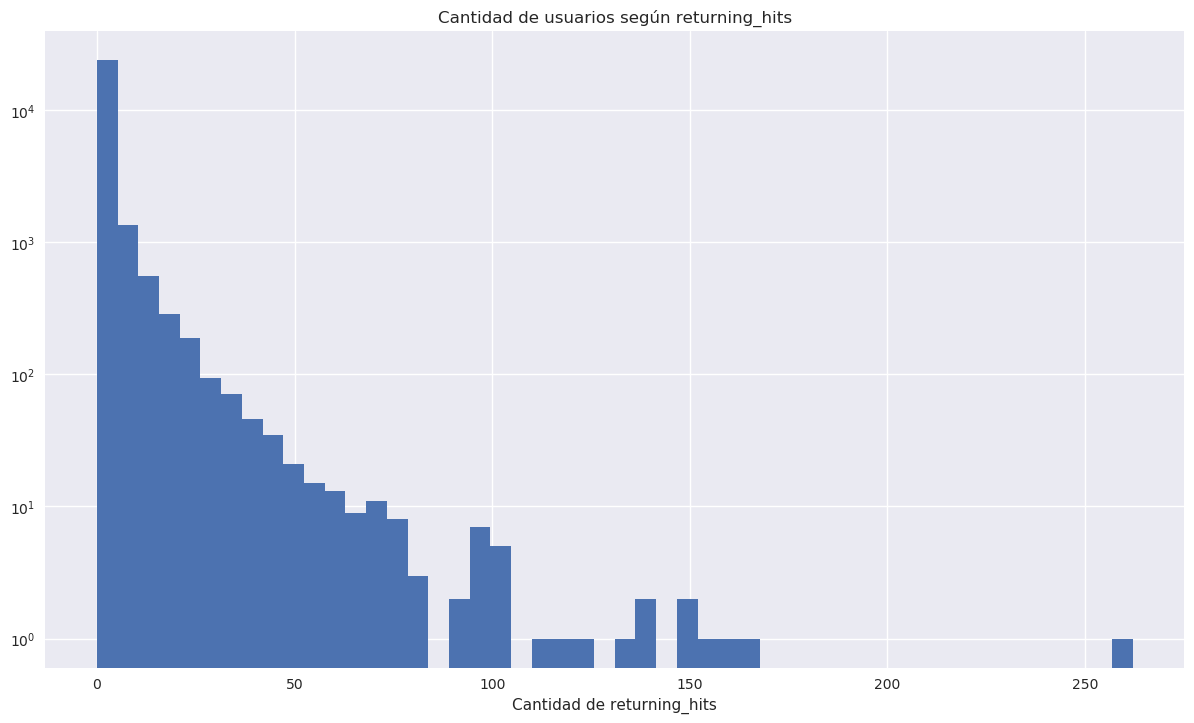

In [98]:
ax = x.hist(bins = 50)
ax.set_yscale('log')
ax.set_title('Cantidad de usuarios según returning_hits')
ax.set_xlabel('Cantidad de returning_hits')

La mayoría de los usuarios ingresa al sitio una única vez

[Text(0,0.5,'Cantidad de Usuarios'),
 Text(0.5,0,'Cantidad de visitas al sitio'),
 Text(0.5,1,'Cantidad de usuarios segun veces que visitaron el sitio')]

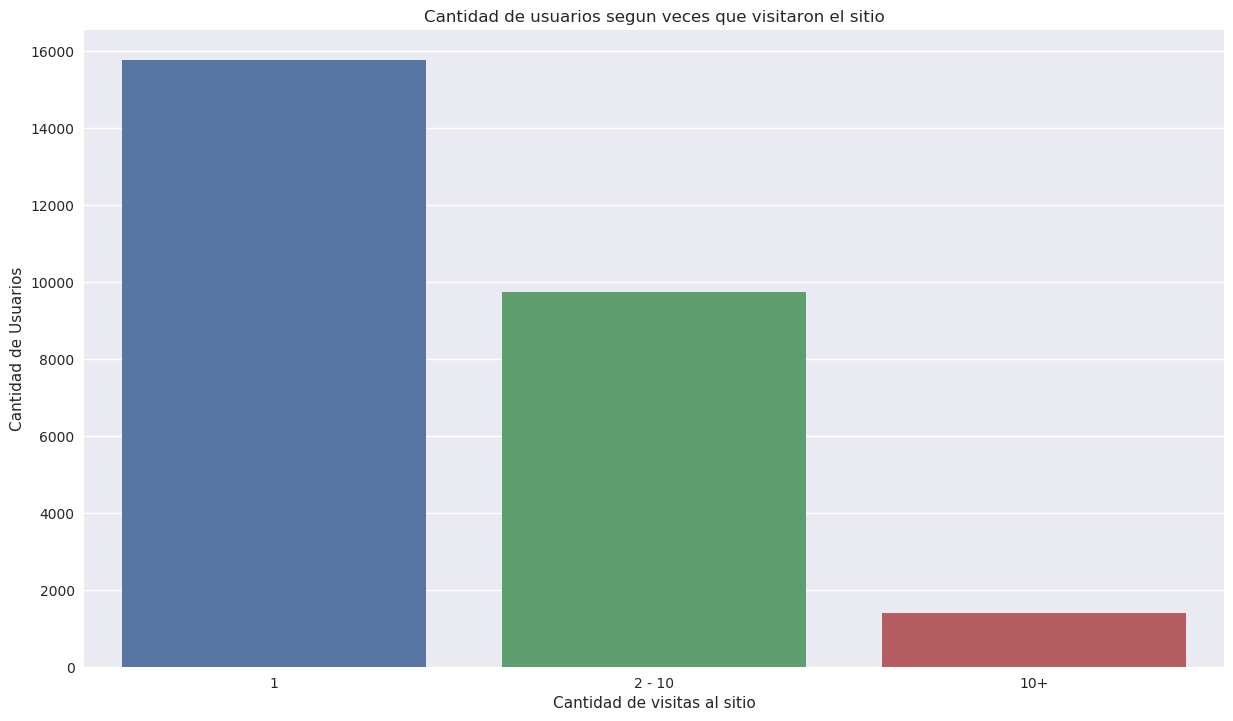

In [99]:
cant_returns = x.value_counts()
cero_returns = cant_returns[0]
uno_diez_returns = cant_returns[1:11].values.sum()
diez_mas_returns = cant_returns[11:].values.sum()
datos_returns = [cero_returns, uno_diez_returns, diez_mas_returns]
x_labels = ['1', '2 - 10', '10+']
ax = sns.barplot(x = x_labels, y = datos_returns)
ax.set(xlabel='Cantidad de visitas al sitio', ylabel='Cantidad de Usuarios', title = 'Cantidad de usuarios segun veces que visitaron el sitio')

La mayoria de los usuarios visita el sitio una única vez, mientras que solo una pequeña proporción volvió al sitio mas de 10 veces. Es posible que un mismo usuario entre desde dispositivos diferentes.

## Analisis temporal

In [100]:
#Analizamos periodo de los datos
df['timestamp'].dt.year.value_counts()

2018    1011288
Name: timestamp, dtype: int64

Todos los datos son de 2018

In [101]:
df['timestamp'].dt.month_name().value_counts()

May         474949
June        281882
April       130008
March        77293
February     27886
January      19270
Name: timestamp, dtype: int64

De los primeros dos trimestres del año

Text(0.5,1,'Cantidad de eventos por dia de la semana')

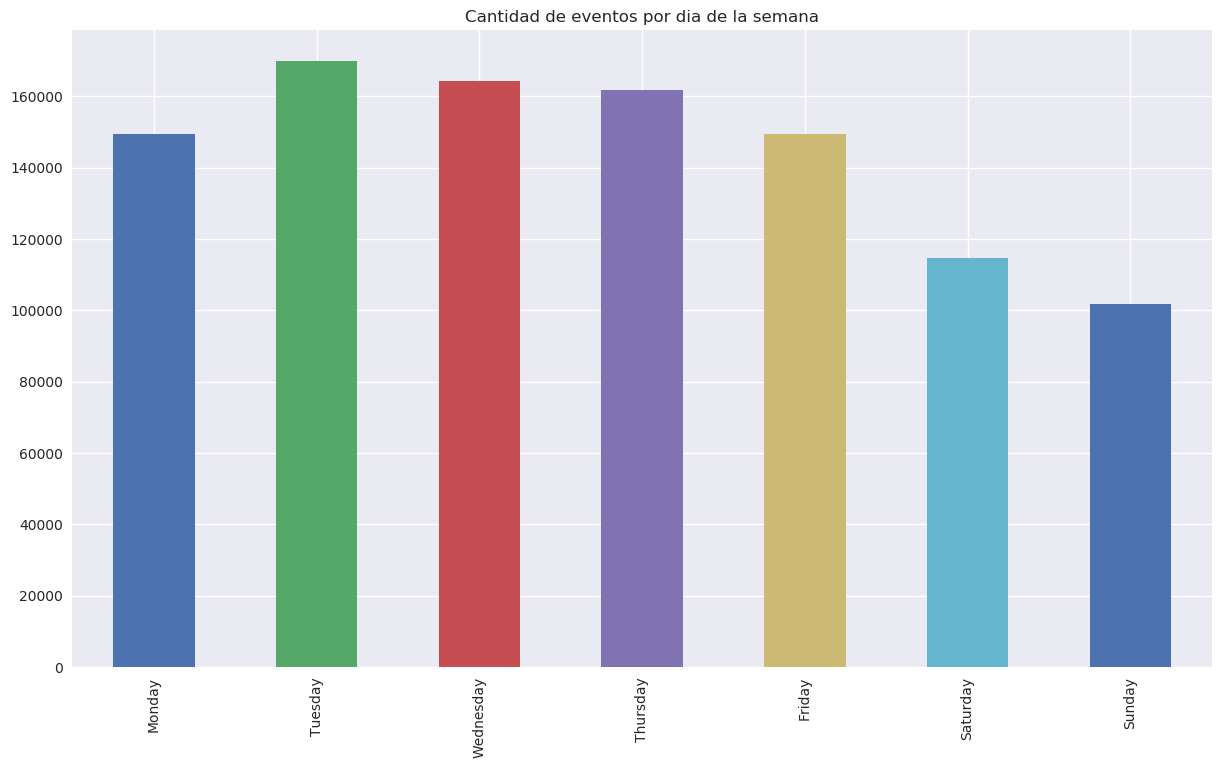

In [102]:
#Vamos a hacer un analisis sobre los dias en los que se produjeron los eventos
dias_semana = df['timestamp'].dt.weekday_name
dias_ordenados = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dias_semana = pd.Categorical(dias_semana, categories = dias_ordenados, ordered = True)
g = dias_semana.value_counts().plot('bar')
g.set_title('Cantidad de eventos por dia de la semana')

Vemos que durante el fin de semana el trafico es menor

In [139]:
tiempo_eventos = pd.DataFrame()
tiempo_eventos['event'] = df['event']
tiempo_eventos['dia_semana'] = df['timestamp'].dt.weekday_name
tiempo_eventos['dia'] = df['timestamp'].dt.day
tiempo_eventos['hora'] = df['timestamp'].dt.hour
tiempo_eventos['mes'] = df['timestamp'].dt.month_name()

#hora_weekday_organic = tiempo_eventos[tiempo_eventos['channel'] == 'organic'].groupby('dia_semana')['hora'].value_counts().to_frame()
#hora_weekday_paid = tiempo_eventos[tiempo_eventos['channel'] == 'paid'].groupby('dia_semana')['hora'].value_counts().to_frame()

hora_weekday_visitas = tiempo_eventos[tiempo_eventos['event'] == 'visited site'].groupby('dia_semana')['hora'].value_counts().to_frame()
hora_weekday_visitas = hora_weekday_visitas.rename(columns = {'hora':'cant_casos'})
hora_weekday_visitas = hora_weekday_visitas.reset_index('hora')
hora_weekday_visitas.index = pd.CategoricalIndex(hora_weekday_visitas.index, categories= reversed(dias_ordenados))
hora_weekday_visitas.sort_index(level=0, inplace=True)
hora_weekday_visitas = hora_weekday_visitas.reset_index()

dia_mes_visitas = tiempo_eventos[tiempo_eventos['event'] == 'visited site'].groupby('mes')['dia'].value_counts().to_frame()
dia_mes_visitas = dia_mes_visitas.rename(columns = {'dia':'cant_casos'})
dia_mes_visitas = dia_mes_visitas.reset_index('dia')
dia_mes_visitas.index = pd.CategoricalIndex(dia_mes_visitas.index, categories= ['January', 'February', 'March', 'April', 'May', 'June'])
dia_mes_visitas.sort_index(level=0, inplace=True)
dia_mes_visitas = dia_mes_visitas.reset_index()

[Text(0,0.5,'Lunes'),
 Text(0,1.5,'Martes'),
 Text(0,2.5,'Miercoles'),
 Text(0,3.5,'Jueves'),
 Text(0,4.5,'Viernes'),
 Text(0,5.5,'Sabado'),
 Text(0,6.5,'Domingo')]

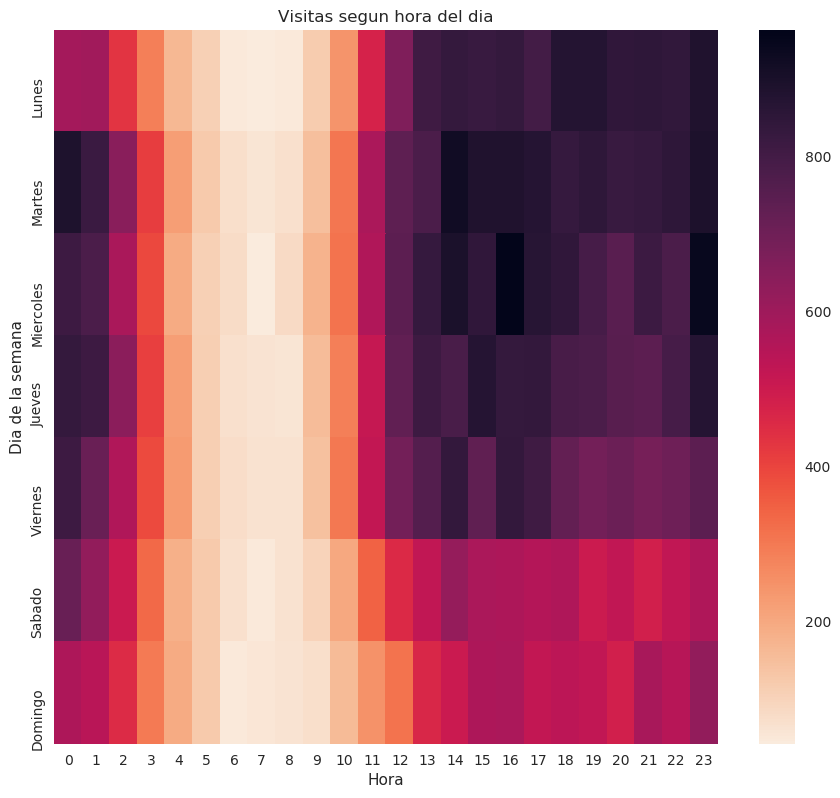

In [140]:
pivot = hora_weekday_visitas.pivot_table(index = 'dia_semana', columns = 'hora', values = 'cant_casos')
cmap = sns.cm.rocket_r
ax = sns.heatmap(data = pivot, cmap = cmap)
ax.set(xlabel='Hora', ylabel='Dia de la semana', title = 'Visitas segun hora del dia')
ax.set_yticklabels(reversed(['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']))

Durante el fin de semana la cantidad de visitas es menor, mientras que la mayoria de las visitas se realizan entre las 12 y las 2

[Text(0.5,0,'Enero'),
 Text(1.5,0,'Febrero'),
 Text(2.5,0,'Marzo'),
 Text(3.5,0,'Abril'),
 Text(4.5,0,'Mayo'),
 Text(5.5,0,'Junio')]

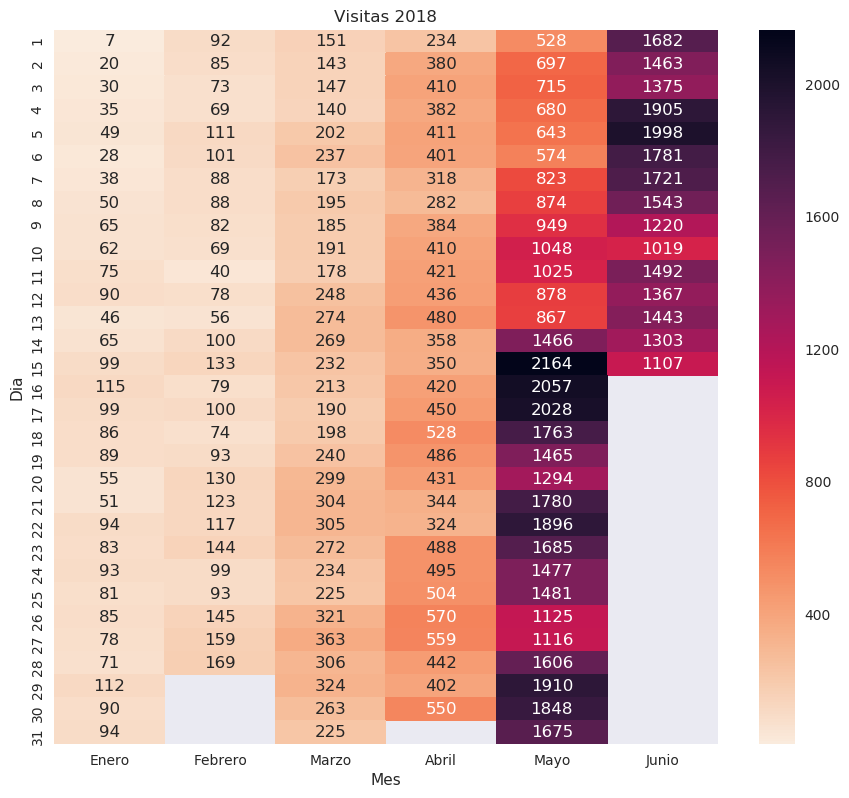

In [105]:
pivot = dia_mes_visitas.pivot_table(index = 'dia', columns = 'mes', values = 'cant_casos')
cmap = sns.cm.rocket_r
sns.set(rc={'figure.figsize':(10.7,9.27)})
ax = sns.heatmap(data = pivot, cmap = cmap, annot = True, fmt=".0f")
ax.set(xlabel='Mes', ylabel='Dia', title = 'Visitas 2018')
ax.set_xticklabels(['Enero','Febrero','Marzo','Abril','Mayo','Junio'])

Las visitas crecieron aceleradamente a lo largo del año, logrando un despegue a partir de mayo. Analizaremos las causas de esto mas adelante

## Origen de las visitas

In [106]:
visitas = df.loc[df["event"] == "visited site", ['timestamp', 'person', 'channel', 'new_vs_returning', 'city', 'region', 'country', 'device_type', 'screen_resolution', 'operating_system_version', 'browser_version']]
colors = {'Paid': 'navy', 'Direct': 'g', 'Organic': 'coral', 'Referral': 'm', 'Social': 'goldenrod', 'Email': 'k', 'Unknown': 'grey'}

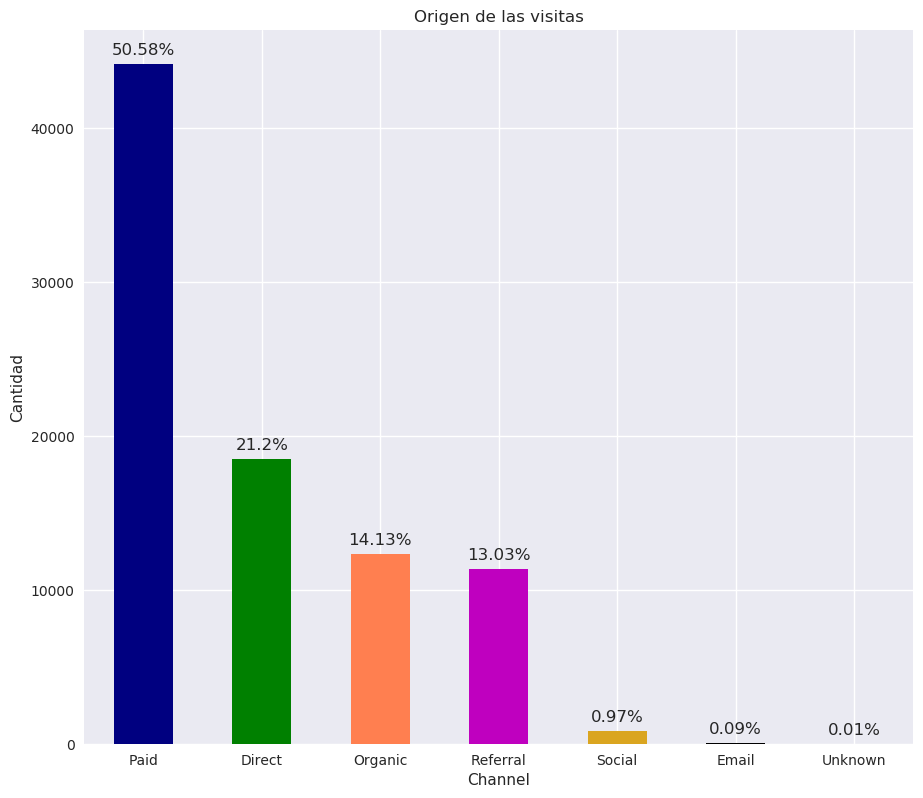

In [107]:
valores = visitas['channel'].value_counts()
ax = valores.plot(kind = 'bar', color=[colors.get(i) for i in valores.index])
ax.set_title('Origen de las visitas')
ax.set_ylabel('Cantidad')
ax.set_xlabel('Channel')
plt.xticks(rotation=0)
mostrar_porcentaje_barplot(ax)

### Origen de usuarios nuevos

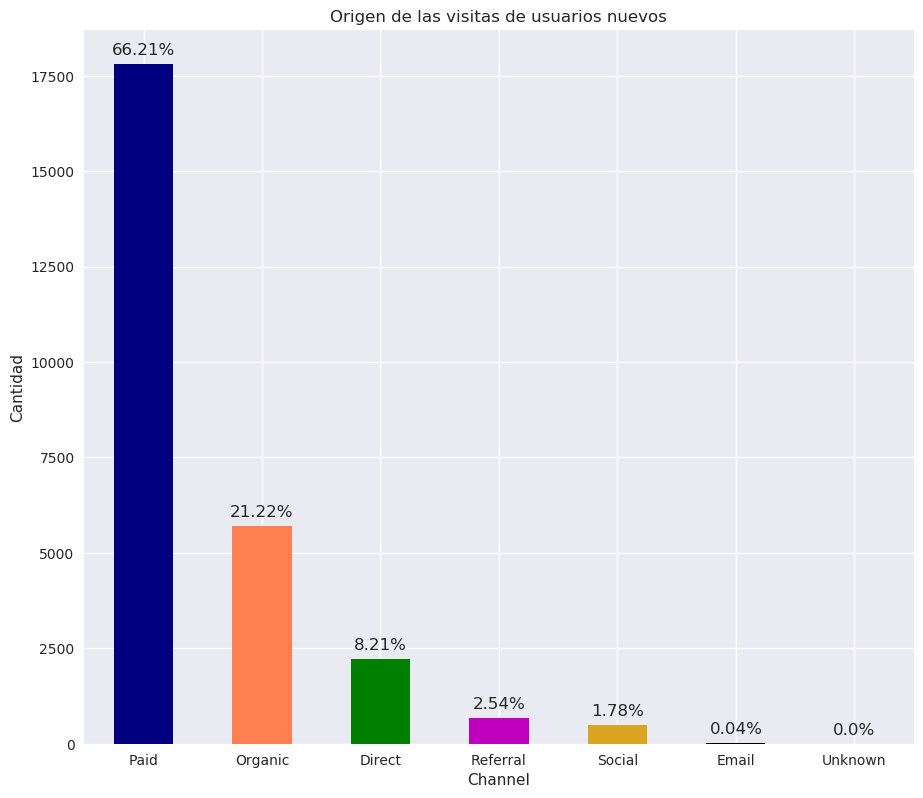

In [108]:
valores = visitas[visitas['new_vs_returning'] == 'New']['channel'].value_counts()
ax = valores.plot(kind = 'bar', color=[colors.get(i) for i in valores.index])
ax.set_title('Origen de las visitas de usuarios nuevos')
ax.set_ylabel('Cantidad')
ax.set_xlabel('Channel')
plt.xticks(rotation=0)
mostrar_porcentaje_barplot(ax)

#### Evolucion canales a lo largo del tiempo para usuarios nuevos

[Text(0,0.5,'Porcentaje'),
 Text(0.5,0,'Mes'),
 Text(0.5,1,'Proporcion de visitas usuarios nuevos por channel')]

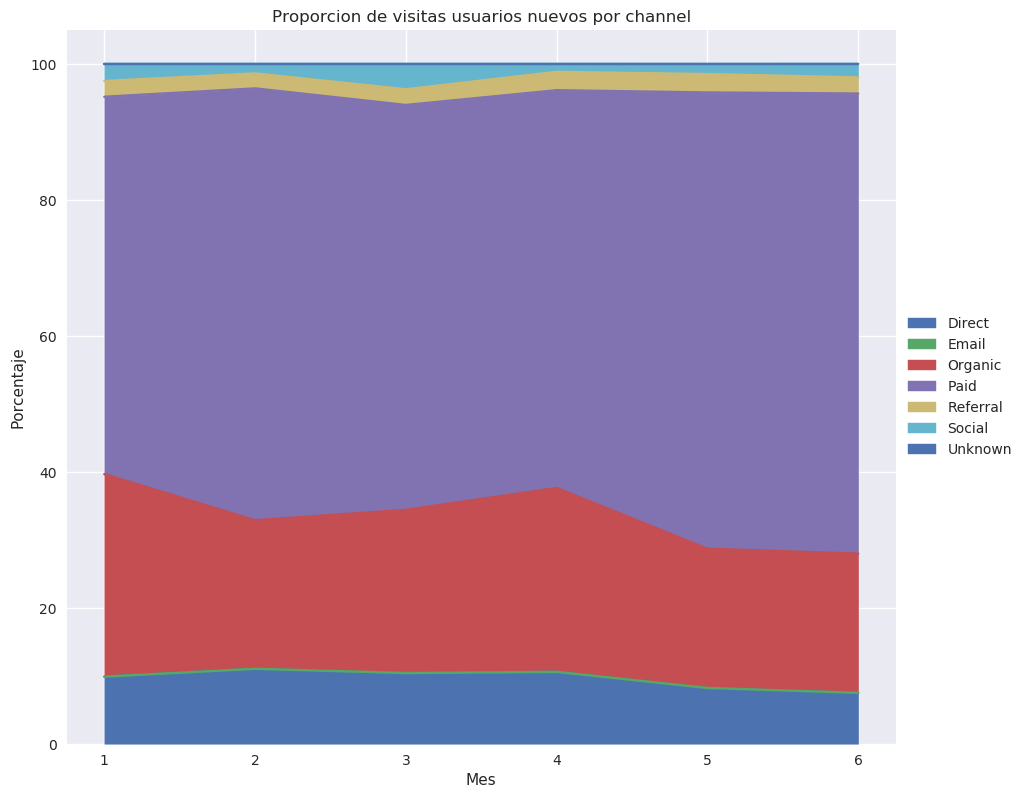

In [109]:
evolucion_semanal = visitas.copy()
evolucion_semanal['mes'] = evolucion_semanal['timestamp'].dt.month
evolucion_semanal = evolucion_semanal[evolucion_semanal['new_vs_returning'] == 'New']

evolucion_semanal = pd.crosstab(evolucion_semanal['mes'], evolucion_semanal['channel'])
evolucion_semanal = evolucion_semanal.div(evolucion_semanal.sum(axis=1), axis=0).multiply(100)

ax = evolucion_semanal.plot(kind = 'area')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set(xlabel='Mes', ylabel='Porcentaje', title = 'Proporcion de visitas usuarios nuevos por channel')

Vemos que los porcentajes se mantienen mas o menos constantes a lo largo del tiempo

### Origen usuarios no nuevos

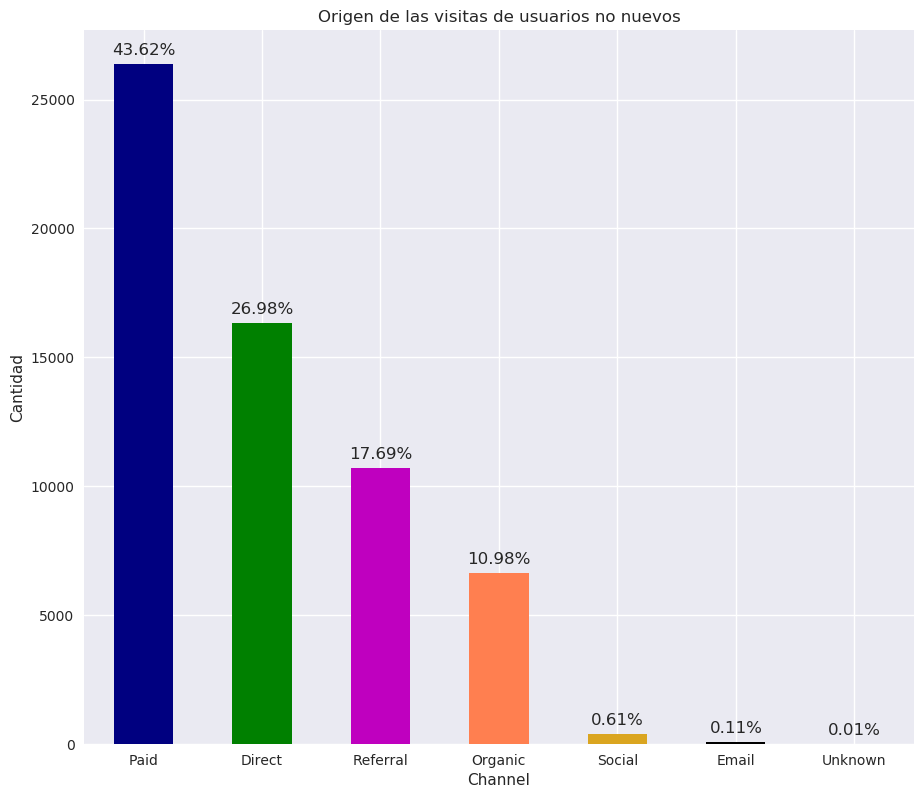

In [110]:
valores = visitas[visitas['new_vs_returning'] == 'Returning']['channel'].value_counts()
ax = valores.plot(kind = 'bar', color=[colors.get(i) for i in valores.index])
ax.set_title('Origen de las visitas de usuarios no nuevos')
ax.set_ylabel('Cantidad')
ax.set_xlabel('Channel')
plt.xticks(rotation=0)
mostrar_porcentaje_barplot(ax)

Vemos que el canal pago es el que mas visitas atrae, no solo para usuarios nuevos sino tambien para usuarios que ya habian entrado al sitio. Por otro lado, se puede ver como el canal "Direct" (tipeado de URL, acceso mediante favoritos y similares) toma protagonismo para visitas de usuarios que ya conocen el sitio. Pero esto puede ser causado por un pequeño numero de usuarios que visitan repetidas veces el sitio

#### Evolución de los canales para visitas de usuarios no nuevos

[Text(0,0.5,'Porcentaje'),
 Text(0.5,0,'Mes'),
 Text(0.5,1,'Proporcion de visitas usuarios no nuevos por channel')]

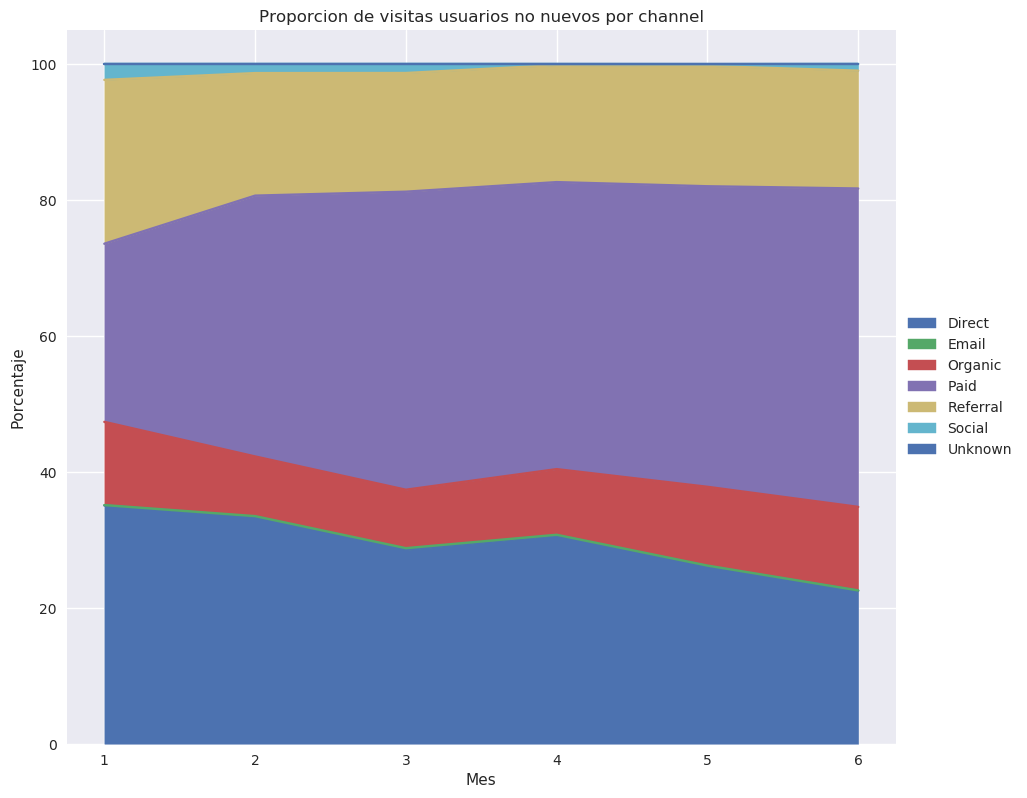

In [142]:
evolucion_semanal = visitas
evolucion_semanal['mes'] = evolucion_semanal['timestamp'].dt.month
evolucion_semanal = evolucion_semanal[evolucion_semanal['new_vs_returning'] == 'Returning']

evolucion_semanal = pd.crosstab(evolucion_semanal['mes'], evolucion_semanal['channel'])
evolucion_semanal = evolucion_semanal.div(evolucion_semanal.sum(axis=1), axis=0).multiply(100)

ax = evolucion_semanal.plot(kind = 'area')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set(xlabel='Mes', ylabel='Porcentaje', title = 'Proporcion de visitas usuarios no nuevos por channel')

Vemos un aumento en proporcion del canal pago y una disminucion del canal directo a lo largo del tiempo.

Ahora tomaremos solo un metodo predominante de acceso al sitio por usuario, para usarios no nuevos

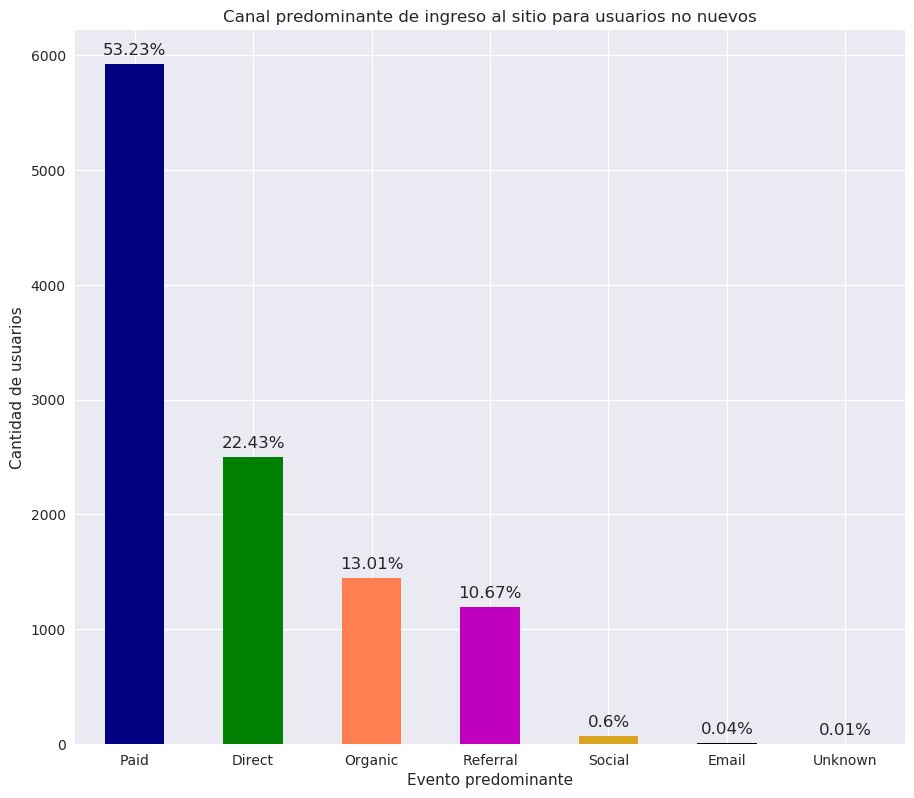

In [112]:
valores = visitas[visitas['new_vs_returning'] == 'Returning'].groupby('person')['channel'].value_counts()
valores = valores.reset_index(level='channel', name='Counts')
valores = valores[~valores.index.duplicated(keep='first')]['channel'].value_counts()
                  
ax = valores.plot(kind = 'bar', color=[colors.get(i) for i in valores.index])
ax.set_title('Canal predominante de ingreso al sitio para usuarios no nuevos')
ax.set_ylabel('Cantidad de usuarios')
ax.set_xlabel('Evento predominante')
plt.xticks(rotation=0)
mostrar_porcentaje_barplot(ax)

Vemos que en este caso el canal predominante de ingreso al sitio para usuarios no nuevos sigue siendo el canal pago, aunque con menor proporcion que para usuarios nuevos. El ingreso mediante "referrals" de otros sitios queda en segundo lugar, teniendo una proporcion mucho mayor que para usuarios nuevos.